In [1]:
def get_decimals(z):
    return float(z.real()) + I*float(z.imag())

DATA CLASSES

In [2]:
from dataclasses import dataclass
@dataclass
class FieldData:
    """Data of an ATR number field for which we will compute a signed fundamental domain."""
    def __init__(self, min_poly, p = None):
        self.source = 'unknown'
        self.min_poly = min_poly
        self.precision = 1000
        self.digits: int = floor(log(2^self.precision, 10))

        self.n = int(self.min_poly.degree(x)) # TODO: why coerce int here -- only casues problems with Espinoza examples?
        self.r = self.n - 2
        
        # setup embeddings
        K.<theta> = NumberField(self.min_poly, embedding = 0.6)
        # note that we need embedding = 0.6 so that RR(theta) makes sense in find_alphas
        self.K = K
        self.theta = theta

        if p == None:
            self.f = K.ideal(1)
        else:
            self.f = K.ideal(p)
        
        if K.signature()[1] == 1:
            print('The field with min_poly', min_poly, 'is ATR.')
        else:
            print('The field with min_poly', min_poly, 'is not ATR.')
        
        self.real_places = []
        self.complex_embeddings = []
        self.embeddings = []
        
        for embedding in K.embeddings(ComplexField(self.precision)):
            if embedding(theta).imag() != 0:
                self.complex_embeddings.append(embedding)
            else:
                self.real_places.append(embedding)
        
        for embedding in self.real_places: 
            self.embeddings.append(embedding)
        for embedding in self.complex_embeddings: 
            self.embeddings.append(embedding)
        
        real_embed = self.real_places[0]
        complex_embed = self.complex_embeddings[0]
        
        complex_theta = complex_embed(self.theta)
        # print('real embed of theta is', round(real_embed(self.theta), 4))
        # print('complex embed of theta is', round(complex_theta.real(), 4), '+', round(complex_theta.imag(), 4), 'I')

        # setup units
        S = []
        # p = 7
        # P = K.prime_above(p)
        # S = [P]
        neg_units = K.S_units(S)       
        self.units = get_positive_units(self.r, self.real_places, neg_units)
    
        print('Positive S-units = ', self.units)
        # print_unit_relations(self.r, neg_units, self.units)

    def print_field_data(self):
        print('Source of data is', self.source)
        print('Min poly is', self.min_poly)
        print('RR of theta is', RR(self.theta))
        print('Real places is', self.real_places)
        print('r is', self.r)
        print('S = ', S, 'and S-units = ', neg_units)
        print('Positive S-units = ', self.units)

In [3]:
from dataclasses import dataclass
@dataclass
class DomainData:
    """Data of a fundamental domain for an ATR number field."""
    def __init__(self, field):
        self.field = field
        self.N = 3
        self.Srtilde = cartesian_product([SymmetricGroup(field.r), range(1, field.r + 2), range(0, self.N)])
        self.zero_cutoff = float(10^(-10))
        self.orientations = dict([])
        self.cones = dict([])
        self.boundaries = dict([])
        self.rotations = dict([])

    def print_cones(self):
        print('Printing cones.')
        for mu in self.cones.keys():
            print('Cone', mu, ' \t orientation = ', self.orientations[mu])
            print('vertices = ', self.cones[mu])
            print('boundaries = ', self.boundaries[mu])
        print('\n')

    def scale_cone_gens(self, ideals):
        """Scale the cone generators so that each one is a primitive element of the given ideals.
        Make sure to update domain with the new cone generators."""
        field = domain.field
        cones = domain.cones
        cone_keys = cones.keys()
        ideal = field.K.ideal(1)
        for multiplicand in ideals: # compute product of the ideals
            ideal *= multiplicand
        ideal_gens = ideal.basis() # get basis of product
        for mu in cone_keys:
            cone_gens = cones[mu]
            for i, cone_gen in enumerate(cone_gens):
                coords = ideal.coordinates(cone_gen) # get coordinates cone_gen in terms of ideal  
                common = gcd(coords) # calculate gcd of rational coordinates
                cone_gens[i] = cone_gen/common # scale cone generator so that it is in the product of ideals

    def choose_rotations(self, weighted = False):
        """Store a dictionary of possible choices of rotations for the given domain, indexed over the cones."""
        if weighted == True:
            print('Choosing rotations with a weighted average.')
        complex_embed = self.field.complex_embeddings[0]
        for mu in self.cones.keys():
            cone_gens = self.cones[mu]
            column = embed(cone_gens, complex_embed)
            self.rotations[mu] = compute_rotation(column, weighted)

POLYNOMIAL SETUP

In [4]:
def Espinoza_domain(example):

    R.<x> = PolynomialRing(ZZ)
    
    fsigdict = dict([])
    xidict = dict([])
    mxidict = dict([])
    orderingsdict = dict([])
    rhodict = dict([])
    
    if example == '3.1.1' or example == '3.1.2':
        degree = 3
        min_poly = x^3 + x^2 - 1
    if example == '3.2.1':
        degree = 4
        min_poly = x^4 + x - 1 # nonzero orientations [0,4]
    if example == 'email':
        degree = 5
        min_poly = x^5 - x^3 - 2*x^2 + 1 # nonzero orientations [13, 0]
    
    field = FieldData(min_poly)
    theta = field.theta

    field.source = 'Espinoza ' + 'example'
    
    if example == '3.2.1':
        complex_embed = field.complex_embeddings[0]
        desired_embed = 0.2481 - 1.0339*I
        if abs(complex_embed(theta) - desired_embed) > 0.01:
            print('Changing embedding because theta = ', complex_embed(theta))
            field.complex_embeddings[0] = field.complex_embeddings[1]
            field.complex_embeddings[1] = complex_embed
        field.complex_embed = field.complex_embeddings[0]
        
    if example == '3.1.1' or example == '3.1.2': # cubic
        field.units[1] = theta # which is the inverse of theta^2 + theta
    if example == '3.2.1': # quartic
        field.units[1] = theta^2
        field.units[2] = theta^2 + 1
    if example == 'email': # quintic
        field.units[1] = theta^2
        field.units[2] = theta^4 - theta^3 - theta + 2
        field.units[3] = theta^4 - theta^3 - theta + 1

    print('Using units =', field.units)

    alpha = []
    if example == '3.1.1': # cubic
        alpha.append(1)
        alpha.append(2*theta^2 + 2*theta + 1)
        alpha.append(2*theta + 1)
    if example == '3.1.2':
        alpha.append(1)
        alpha.append(theta^2 + theta)
        alpha.append(theta)
    if example == '3.2.1': # quartic
        alpha.append(1)
        alpha.append(theta^2 - theta + 1)
        alpha.append(theta^2 + theta)
    if example == 'email': # quintic
        alpha.append(1)
        alpha.append(theta^2)
        alpha.append(theta^(-2))

    return compute_fundamental_domain(field, alpha)

In [5]:
def RS_domain(example):
    R.<x> = PolynomialRing(ZZ)

    if example == '4.1.1': # TODO: the rho's do not sum to 0 for only this example
        # this is the only example for which f is a ramified prime...
        # TODO: check that epsilon = theta - 1 is indeed an f-unit with f = (3)
        min_poly = x^3 - 2
        f = 3
    if example == '4.2.1':
        min_poly = x^3 - x + 1
        f = 5
    
    field = FieldData(min_poly, f)
    field.source = 'RS ' + example
    return compute_fundamental_domain(field)

In [6]:
def get_random_field_data(degree):
    
    R.<x> = PolynomialRing(ZZ)
    
    # setup polynomial
    if degree == 7:
        min_poly = x^7 - 5*x^6 - x^5 + x^4 - x^3 + 6*x^2 + x - 1 # nonzero orientations = [1095, 1065], 
        # 1.5 min to compute originally (+ 2.5 min to check)
        # 14 sec with new compute_orderings
        # 13 sec with new compute_rhos
    elif degree == 8:
        min_poly = x^8 - 6*x^7 - x^6 + 23*x^5 - 3*x^4 - 3*x^3 - 6*x^2 + 1 # nonzero orientations = [2284, 3044]
        # 2 min to compute with new compute_orderings and rhos, gives nonzero orientations = [6880, 8240] 
        # 30 sec with new compute_alphas
        # note: this min_poly has 4 positive real roots, and 2 negative real roots
    elif degree == 9:
        min_poly = x^9 - 7*x^8 + 2*x^7 + 3*x^6 + x^5 + 51*x^4 - 6*x^3 - 15*x^2 + x + 1 # nonzero orientations = [68317, 52643]
        # 45 min to compute with new compute_orderings
        # 42 min to compute with new compute_rhos
        # 6 min to compute with new compute_alphas, gives nonzero orientations = [25079, 22729]
    else:
        min_poly = random_ATR_poly(degree)
    
    field = FieldData(min_poly)
    return field

In [7]:
def random_ATR_poly(degree): # ToDo: alternative to brute force
    # return random polynomial of given degree which generates an ATR field
    R.<x> = PolynomialRing(ZZ)
    poly = x^degree
    L = poly.list()
    count = 0
    while count < 10^degree:
        count += 1
        if poly.is_irreducible(): # if irreducible
            K.<theta> = NumberField(poly)
            num_complex = K.signature()[1]
            if num_complex == 1: # check signature
                return poly # if ATR field, done
        # if didn't return, then need new polynomial
        lower = R.random_element(degree - 1) # choose random lower degree part
        poly = x^degree + lower
        L = poly.list() #get the coefficients
    print('Didn\'t find a good ATR polynomial!')
    poly = 1 # default if no polynomial found
    return poly

SIGNATURES & UNITS

In [8]:
def get_signatures(r, real_places, units):
    """Return signature matrix for given units. 
    Skip first unit, assumed -1."""
    signatures = []
    for index in range(1,r+1): # skip the first unit (at index 0) which equals -1
        unit = units[index]
        signature = []
        for place in real_places:
            if place(unit) < 0:
                signature.append(1)
            else:
                signature.append(0)
        signatures.append(signature)
    
    Mrbyr = MatrixSpace(GF(2), r, r)
    signatures = Mrbyr(matrix(signatures))
    return signatures

In [9]:
def get_positive_units(r, real_places, neg_units):
    """Return basis of totally positive units from array of potentially non-positive units 
    Skip/ignore first unit, assumed -1."""
    # print('Getting positive units')
    signatures = get_signatures(r, real_places, neg_units)
    rank = signatures.rank()
    # print(signatures)
    # print('original rank = ', rank)
    
    units = [-1]
    counts = [0 for _ in range(0,r)]
    
    kernel = signatures.kernel().basis()
    for vector in kernel: # record multiplicative combo of units determined by each kernel vector
        unit = 1
        for index in range(0, r):
            if vector[index]: # if is 1, then include in positive unit
                unit *= neg_units[index + 1] # add 1 to skip/ignore first unit
                counts[index] += 1
        units.append(unit)
    
    import numpy
    indices = numpy.argsort(counts)
    count = 0
    for index in indices: # go through counts in increasing order, stopping once hit rank
        if count == rank:
            break
        count += 1
        unit = neg_units[index + 1]^2
        units.append(unit)

    signatures = get_signatures(r, real_places, units)
    rank = signatures.rank()
    # print('new rank = ', rank)
    
    return units

In [10]:
def print_unit_relations(r, neg_units, units):
    """Print the relations among neg_units which give the values of units."""
    for num_combo in range(1,r+1):
        for combo in Combinations(range(1,r+1), num_combo): # combinations are unordered, without repititition
            product = 1
            for index in combo:
                product *= neg_units[index]
            for index in range(1,r+1):
                if units[index] == product:
                    print(combo, 'gives positive unit', index)
    
    for neg_index in range(1,r+1):
        squared = neg_units[neg_index]^2
        for index in range(1,r+1):
            if units[index] == squared:
                print(neg_index, 'squared gives positive unit', index)

COMPUTING F'S

First we define $f_{t, \sigma}$ for $1 \leq t \leq r + 1$ and $\sigma \in S_r$

In [11]:
def compute_fsigs(domain):
    """Compute and store f_{t,sigma} for 1 <= t <= r + 1 and sigma in Sr."""
    units = domain.field.units
    r = domain.field.r
    
    fsigdict = dict([])
    for sigma in SymmetricGroup(r):
        fsigdict[(1,sigma)] = 1
        for t in range(1, r + 2):
            f = 1
            for index in range(1,t): # skip the first unit (at index 0) which equals -1
                f *= units[sigma(index)]
            fsigdict[(t,sigma)] = f
    return fsigdict

DEFINITION OF the $\xi$ values

In [12]:
def compute_xis(domain, fsigdict):
    """Compute and store xi_{sigma}(t1,t2) for 1 <= t1,t2 <= r+1
    Return as a dictionary indexed by sigma, t1, and t2."""
    r = domain.field.r
    complex_embed = domain.field.complex_embeddings[0]
    
    xidict = dict([])
    for sigma in SymmetricGroup(r):
        for t1 in range(1, r+2):
            for t2 in range(1, r+2):
                f1 = fsigdict[(t1, sigma)]^(-1)
                f2 = fsigdict[(t2, sigma)]
                xidict[(sigma,t1,t2)] = complex_embed(f1*f2)
    return xidict

In [13]:
def check_xis(domain, xidict):
    """Verify Espinoza equation (7)."""
    r = domain.field.r
    zero_cutoff = domain.zero_cutoff
    
    for sigma in SymmetricGroup(r):
        print('Checking Espinoza equation (7) for sigma = ', sigma)
        for t1 in range(1, r+2):
            for t2 in range(1, r+2):
                # check symmetry
                LHSsymmetry = xidict[(sigma, t1,t2)]^(-1)
                RHSsymmetry = xidict[(sigma,t2,t1)]
                symmetryin7 = LHSsymmetry - RHSsymmetry
                if not abs(symmetryin7) < zero_cutoff:
                    print('Symmetry in (7) broken: \t LHS = ', LHSsymmetry, '\t RHS = ', RHSsymmetry)
                    
                # check adjunction
                LHSadjunction = xidict[(sigma, r+1, t1)]*xidict[(sigma, r+1, t2)]^(-1)
                RHSadjunction = xidict[(sigma, t2, t1)]
                adjunctionin7 = LHSadjunction - RHSadjunction
                if not abs(adjunctionin7) < zero_cutoff:
                    print('Adjunction in (7) broken: \t LHS = ', LHSadjunction, '\t RHS = ', RHSadjunction)
                    
                # check transitivity                    
                for t3 in range(1, r+2):
                    LHStransitivity = xidict[(sigma,t1,t2)]*xidict[(sigma,t3,t1)]
                    RHStransitivity = xidict[(sigma,t3,t2)]
                    transitivityin7 = LHStransitivity - RHStransitivity
                    if not abs(transitivityin7) < zero_cutoff:
                        print('Transitivity in (7) broken: \t LHS = ', LHStransitivity, '\t RHS = ', RHStransitivity)
                        
    print('Done checking Espinoza equation (7) \n')       

DEFINITION OF the function $m = m_N$

In [14]:
def m(z, N):
    # note that Sage uses the principal branch cut i.e. argument in (-pi, pi]
    # ToDo: does it matter that Espinoza uses arguments in [-pi, pi) ?
    argument = z.arg()
    if argument == RR(pi):
        print('Whoopsie: argument of pi in calculation of m')
        argument = argument - 2*RR(pi)
    return ceil(-N*argument/(2*RR(pi)))

STORAGE OF the values $m(\xi)$ in a dictionary

In [15]:
def compute_mxis(domain, xidict):
    """Return a dictionary with m(xi_{sigma}(t)) for 1 <= t <= r + 1 and sigma in Sr."""
    # note that swapping r+1 and t below permutes the mxis, but does not change the values themselves.
    r = domain.field.r
    N = domain.N
    mxidict = dict([])
    for sigma in SymmetricGroup(r):
        for t in range(1,r+2):
            mxidict[sigma,t] = m(xidict[(sigma, r+1, t)], N)
    # print('Mxis computed! \n')
    return mxidict

DEFINITION OF strict total order on $\{1, \ldots, r + 1\}$ for general $r$. 

In [16]:
def compute_orderings(domain, xidict, mxidict): 
    """Use Python built-in sorting algorithm.
    Return a dictionary with a good ordering for each sigma in Sr.
    This ordering is the strict total order <_{sigma} of Espinoza."""
    from functools import cmp_to_key
    r = domain.field.r
    N = domain.N
    
    orderingsdict = dict([])
    for sigma in SymmetricGroup(r):
        indices = list(range(1, r+2))
        indices.reverse() # reverse list to make more efficient when not checking
        orderingsdict[sigma] = sorted(indices, key = cmp_to_key(lambda i,j : -less(N, sigma, i,j, xidict, mxidict) + 1/2))
    return orderingsdict

In [17]:
def less(N, sigma, t1, t2, xidict, mxidict):
    """Ceck if t1 <_sigma t2. Return True if 'yes', False if 'no'."""
    LHS9 = m(xidict[(sigma, t1, t2)], N) % N
    RHS9 = (mxidict[sigma, t2] - mxidict[sigma, t1]) % N
    result9 = (LHS9 == RHS9)            
    if not result9: # equation (9) is required for each good pair
        lemma4 = (LHS9 == ((RHS9 + 1) % N)) # lemma 4 says that even bad pairs satisfy LHS9 \equiv RHS9 + 1 mod N
        if not lemma4: 
            print("We broke lemma 4!")
            print('sigma = ', sigma, '\t t1, t2 = ', t1, t2)
        return False 
    
    LHS10 = (LHS9 + m(xidict[(sigma, t2, t1)], N)) % N
    result10 = (LHS10 == 1)
    result11 = (t2 < t1)
    if not (result10 or result11):
        return False

    return True # the pair checked out  

In [18]:
def compare(sigma, t1, t2, orderingsdict): 
    # return True if t1 <_sigma t2
    ordering = orderingsdict[sigma]
    return (ordering.index(t1) < ordering.index(t2))

DEFINITION OF the $\rho_\sigma$

In [19]:
def compute_Espinoza_rhos(domain, orderingsdict): 
    """Return a dictionary with rho_{sigma} for each sigma in Sr.
    Compute as product of 2-cycles.
    This rho gives separation of {r+1 < r < ... < 2 < 1} from strict total order <_{sigma} of Espinoza."""
    r = domain.field.r
    
    rhodict = dict([])
    for sigma in SymmetricGroup(r):
        ordering = orderingsdict[sigma].copy()
        rho = SymmetricGroup(r+1).identity()
        
        for number in range(1, r + 2):
            current_index = ordering.index(number) # current index of number in ordering
            desired_index = r + 1 - number # index of number in {r +1 < r < ... < 2 < 1}
            in_my_spot = ordering[desired_index]
            pair = (number,) + (in_my_spot,)
            if pair[0] != pair[1]:
                rho *= PermutationGroupElement(pair)
                ordering[current_index] = in_my_spot
                ordering[desired_index] = number
                
        rhodict[sigma] = rho^(-1)
    return rhodict

DEFINITION OF the $\alpha$'s

In [20]:
def find_alpha(domain, t):
    """Return an element of K+ satisfying the conditions of Espinoza's 7SA, step 4."""
    # ToDo: more refined algorithm for coefficient-based checking?
    r = domain.field.r
    N = domain.N
    theta = domain.field.theta
    complex_embed = domain.field.complex_embeddings[0]
    units = domain.field.units
    L.<rootunityN> = NumberField(cyclotomic_polynomial(N), embedding = e^(-2*RR(pi)*I/N))
    
    def is_good_alpha(candidate):
        if RR(candidate) < 0:
            # print('alpha candidate is not totally positive', RR(candidate))
            return False
        argument = (complex_embed(candidate)*rootunityN^t).arg() # TODO: work in unified field?
        if -RR(pi)/(2*N) < argument and argument < RR(pi)/(2*N): # if satisfies Espinoza's condition on alpha
            # note that neither an argument of -pi or +pi works here
            # print('for t =', t, 'alpha^{1} =', RR(candidate), 'argument =', argument)
            return True
        else:
            return False
    
    if is_good_alpha(1): # try simplest possible alpha
        return 1
    for _ in range(1, r+1): # try alphas which are powers of fundamental unit
        unit = units[_]
        if is_good_alpha(unit):
            return unit
        if is_good_alpha(unit^(-1)):
            return unit^(-1)
    for coefficients in Tuples(range(-N,N), r + 1).list(): # Tuples are ordered, with repitition
        exponent = 0
        candidate = 0
        for coefficient in coefficients: # build candidate alpha from coefficients 
            candidate = candidate + coefficient*(theta^exponent)
            exponent += 1
        if candidate == 0: # want default candidate to be 1
            candidate = 1
        if is_good_alpha(candidate):        
            return candidate # have found alpha so don't need to keep searching
    print('We didn\'t find any alphas!?')

In [21]:
def compute_alphas(domain):
    """Return a dictionary with alpha_{t} for each residue t modulo N."""   
    N = domain.N

    alpha = dict([])
    for t in range(0,N):
        alpha[t] = find_alpha(domain, t)
    # print('pi/2N = ', RR(pi)/(2*N))
    # print('Alphas computed! \n')
    return alpha

COMPUTATION OF f's

In [22]:
def compute_fmus(domain, fsigdict, mxidict, orderingsdict, rhodict, alpha):
    """Return a dictionary with f_{sigma, mu} for sigma in Sr and mu in Srtilde."""
    r = domain.field.r
    N = domain.N
    
    fmudict = dict([])
    
    for mu in domain.Srtilde:
        sigma = mu[0]
        q = mu[1]
        n = mu[2]
            
        for t in range(1,r+2):
            mxi = mxidict[sigma, t]
            less = compare(sigma, t, rhodict[sigma](q), orderingsdict)
            if less:
                alphat = (mxi + n + 1) % N 
            else:
                alphat = (mxi + n) % N
            fmudict[(t,mu)] = fsigdict[(t, sigma)]*alpha[alphat]
        t = r + 2
        alphat = (mxidict[sigma, rhodict[sigma](q)] + n + 1) % N
        fmudict[(t, mu)] = fsigdict[(rhodict[sigma](q), sigma)]*alpha[alphat]
    # print('F mus computed! \n')
    return fmudict

COMPUTATION OF the orientations

In [23]:
def compute_orientations(domain, fmudict):
    """Return a dictionary with the orientations w_{mu} for mu in Srtilde.
    If determinants are less than the zero_cutoff, make w_{mu} equal zero."""
    r = domain.field.r
    units = domain.field.units
    real_places = domain.field.real_places
    complex_embed = domain.field.complex_embeddings[0]
    zero_cutoff = domain.zero_cutoff
    orientations = domain.orientations
    # compute determinant in denominator (doesn't depend on mu)
    matrixeps = [] 
    for t in range(1,r+1): # index rows by fund units
        epsilon = units[t]
        matrixeps.append([])
        for place in real_places: # index columns by real places
            embeddedep = place(epsilon)
            logarithm = ln(abs(embeddedep))
            matrixeps[t-1].append(logarithm)
    epsdeterminant = matrix(matrixeps).det()
    # now we'll compute the numerator determinants, and divide
    num_nonzero = [0,0]
    count = 0
    for mu in domain.Srtilde:    
        sigma = mu[0]
        matrixfs = []
        for t in range(1,r + 3): # index rows by t
            matrixfs.append([])
            algf = fmudict[(t,mu)]
            k = 1
            # index columns by places, complex places first
            matrixfs[t-1].append(complex_embed(algf).real())
            matrixfs[t-1].append(complex_embed(algf).imag())
            for place in real_places: # then add real
                embeddedf = place(algf)
                matrixfs[t-1].append(embeddedf)
            
        fsdeterminant = matrix(matrixfs).det()

        quotient = fsdeterminant/epsdeterminant
        if abs(quotient) < zero_cutoff: # check if determinants are close to 0
            w = 0
        else:
            w = sigma.sign()*sign(epsdeterminant)*sign(fsdeterminant)
            if w == -1:
                num_nonzero[0] += 1
            else:
                num_nonzero[1] += 1
        orientations[mu] = w

        count += 1
        
    print('Counts of nonzero orientations, listed -1,1: \t', num_nonzero, '\n')
    # print('\n (including 0\'s, total of', count, 'orientations) \n')
    return orientations

DEFINITION OF the cones

In [24]:
def compute_cones(domain_data, fmudict):
    """Return a dictionary with the cones w_{mu} for mu in Srtilde.
    Do not include cones with orientation equal to zero."""
    r = domain_data.field.r
    orientations = domain_data.orientations
    cones = domain_data.cones
    boundaries = domain_data.boundaries
    
    count = 0
    for mu in domain_data.Srtilde:
        if orientations[mu] != 0:
            count += 1
            vertices = []
    
            for t in range(1, r + 3):
                vertex = fmudict[(t,mu)]
                vertices.append(vertex)

            perturbations = []
            for vertex in vertices:
                plane_basis = copy(vertices)
                plane_basis.remove(vertex)
                # a boundary is closed (i.e. perturbation = False) if in the "half space of Q"
                perturbation = not in_half_space_of_Q(vertex, plane_basis, domain_data.field)  
                perturbations.append(perturbation)
            
            cones[mu] = vertices
            boundaries[mu] = perturbations
            
    print('The total number of cones is ', count, '\n')
    return cones

In [25]:
def in_half_space_of_Q(vertex, plane_basis, field):
    """Determine whether or not vertex is in the same half-space as the n-th standard basis vector.
    Return True if 'yes', False otherwise."""
    plane_embeddings = Minkowski_embed(field, plane_basis)
    
    Q = list((0,)*(field.n - 1) + (1,))
    Q_matrix = plane_embeddings + [Q]    
    Q_determinant = matrix(Q_matrix).det()

    embedded_vertex = Minkowski_embed_alg_num(field, vertex)
    vertex_matrix = plane_embeddings + [embedded_vertex]
    vertex_determinant = matrix(vertex_matrix).det()

    return sign(Q_determinant) == sign(vertex_determinant)

COMPUTATION OF CONES by calling main functions

In [26]:
def compute_fundamental_domain(field, alpha = None):
    """Return a DomainData object with a fundamental domain for the given ATR field.
    Use the parameterized alpha if not None."""

    print('\nComputing Shintani domain for ATR field of', field.min_poly, '\n')
    
    domain = DomainData(field)
    
    fsigdict = compute_fsigs(domain) # uses r
    xidict = compute_xis(domain, fsigdict) # uses r, complex_embed
    mxidict = compute_mxis(domain, xidict) # uses r, N
    
    orderingsdict = compute_orderings(domain, xidict, mxidict) # uses r, N
    # orderingsdict = old_compute_orderings(domain, orderingsdict, checking)
    rhodict = compute_Espinoza_rhos(domain, orderingsdict) # uses r
    # rhodict = old_compute_Espinoza_rhos(checking)
    
    if alpha == None:
        alpha = compute_alphas(domain) # uses r, N, theta, complex_embed
    
    fmudict = compute_fmus(domain, fsigdict, mxidict, orderingsdict, rhodict, alpha) # uses r, N
    
    orientations = compute_orientations(domain, fmudict) # uses r, units, real_places, complex_embed, zero_cutoff
    cones = compute_cones(domain, fmudict)

    return domain

EMBEDDINGS & ROTATIONS

In [27]:
def Minkowski_embed_alg_num(field, alg_num):
    """Minkowski embed the given alg_num."""
    complex_embed = field.complex_embeddings[0]
    embedding = []
    embedding.append(round(float(complex_embed(alg_num).real()), ndigits = field.digits)) # add complex embedding
    embedding.append(round(float(complex_embed(alg_num).imag()), ndigits = field.digits))
    for place in field.real_places: # add real embeddings 
        embedding.append(round(float(place(alg_num)), ndigits = field.digits))
    return embedding

In [28]:
def Minkowski_embed(field, alg_nums, threshold = 50):
    """For each algebraic number (an expression in the primitive generator of field), compute its vector of embeddings.
    Return the results as a list of vectors."""
    embeddings = []
    for alg_num in alg_nums:
        embeddings.append(Minkowski_embed_alg_num(field, alg_num))
    return embeddings

In [29]:
def tracked_Minkowski_embed(field, alg_nums):
    """For each algebraic number (an expression in the primitive generator of field), compute its vector of embeddings.
    Return the results as a dictionary from algebraic numbers to embeddings."""
    embeddings = dict([])
    for alg_num in alg_nums:
        embeddings[alg_num] = Minkowski_embed_alg_num(field, alg_num)
    return embeddings

In [30]:
def embed(alg_nums, embedding):
    """Return list of embedding applied to alg_nums."""
    column = []
    for alg_num in alg_nums: # form colum from embedded generators
        column.append(embedding(alg_num))
    return column

In [31]:
def compute_rotation(column, weighted = False):
    """Compute a complex number z (of absolute value 1) such that z*column has entries with positive real parts.
    If no such complex number exists, return 1."""

    from fractions import Fraction
    
    def my_arg(z):
        """Calculate the argument of the complex number z with branch cut in [0, 2pi)."""
        argument = arg(z)
        if argument < 0:
            argument += 2*pi
        return float(argument)

    def average_arg_rotation(column):
        min_arg = 2*RR(pi)
        max_arg = 0
        for value in column:
            argument = my_arg(value)
            if argument < min_arg:
                min_arg = argument
            if max_arg < argument:
                max_arg = argument
        
        average_arg = (min_arg + max_arg)/2
        rational_piece = Rational(Fraction(float(average_arg/pi)).limit_denominator(max_denominator = 10^5))
        rotation = exp(-rational_piece*pi*I) # absolute value 1 by e^(pure complex) 
        return rotation

    def weighted_average_arg_rotation(column):
        abs_min_num = 1
        abs_max_num = 1
        min_arg = 2*RR(pi)
        max_arg = 0
        for value in column:
            argument = my_arg(value)
            if argument < min_arg:
                min_arg = argument
                abs_min_num = abs(value)
            if max_arg < argument:
                max_arg = argument
                abs_max_num = abs(value)
        
        average_arg = (abs_min_num*min_arg + abs_max_num*max_arg)/(abs_min_num + abs_max_num)
        rational_piece = Rational(Fraction(float(average_arg/pi)).limit_denominator(max_denominator = 10^5))
        rotation = exp(-rational_piece*pi*I) # absolute value 1 by e^(pure complex) 
        return rotation

    def check_good(column, candidate):
        good = True
        for value in column:
            if not float((value*candidate).real()) > 0:
                # print('Even after rotation, we still have a column entry with non-positive real part!')
                # print('Entry =', value, 'has argument', my_arg(value))
                good = False
        return good

    # get candidate rotation
    if not weighted:
        candidate = average_arg_rotation(column)
    if weighted:
        candidate = weighted_average_arg_rotation(column)
    # return if checks out (positive real part)
    if check_good(column, candidate):
        return candidate
    # otherwise, rotate by pi/2 and try again
    # print('Nudging by pi/2.')
    nudge = exp(pi/2*I)
    column2 = [col*nudge for col in column]
    candidate2 = average_arg_rotation(column2)
    if check_good(column, candidate2*nudge):
        return candidate2*nudge
    # otherwise, rotate by -pi/2 and try again
    # print('Nudging by -pi/2')
    nudge = exp(-pi/2*I)
    column2 = [col*nudge for col in column]
    candidate2 = average_arg_rotation(column2)
    if check_good(column, candidate2*nudge):
        return candidate2*nudge
    print('Did not find good rotation!')
    return 1 # default return value if nothing else works

GRAPHING DOMAINS

In [32]:
def graph_domain(domain):
    """Graph the Shintani domain as a projection onto the complex coordinates C."""
    rotations = dict([])
    for mu in domain.cones.keys():
        rotations[mu] = 1
    graph_rotated_domain(domain, rotations)

In [33]:
# Notes on types that came up when debugging this code:
# - returns from 'choose_rotations(domain)' are in complex_double.ComplexDoubleElement, complex numbers of 64-bit ('double') precision
# - returns from any field embedding are in complex_mpfr.ComplexNumber, complex numbers of Arbitrary precision
# - the 'numpy.set_printoptions' only works for the second kind of complex number
# - using 'pi', instead of 'RR(pi)', results in 'expressions', rather than (floating point) complex numbers
# - the 'Polyhedron" constructor requires vertices to be more precise than 'expression'

def graph_rotated_domain(domain, rotations = None):
    """Graph the rotated Shintani domain as a projection onto the complex coordinates C."""
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from itertools import cycle
    import numpy as np
    np.set_printoptions(formatter={'complex_kind': '{:.2f}'.format})
    np.set_printoptions(precision=2, suppress=True)

    if rotations == None: # if no rotations override given, use those stored in the domain
        rotations = domain.rotations    
    
    neg_cmap = mpl.colormaps["tab10"]  # type: matplotlib.colors.ListedColormap
    pos_cmap = mpl.colormaps["Pastel1"]
    neg_colors = cycle(neg_cmap.colors)
    pos_colors = cycle(pos_cmap.colors)
    # graph.set_prop_cycle(color = colors)
    # colors = iter(cm.rainbow(np.linspace(0, 1, len(cones))))
    complex_embed = domain.field.complex_embeddings[0]

    # fig = plt.figure(figsize = (6,6))  # instantiates medium figure

    min_x, max_x, min_y, max_y = (0,)*4
    
    graph = Graphics()
    for mu in domain.cones.keys():
        cone_gens = domain.cones[mu]
        rotated_vertices = get_rotated_vertices(domain, mu, complex_embed, rotations)
        # TODO: do we want to normalize by dividing by one or more real embedding
        for real_embedding in domain.field.real_places:
            embedded_vertices = embed(cone_gens, real_embedding)
            for j in range(0, len(embedded_vertices)):
                rotated_vertices[j] /= embedded_vertices[j]

                # x_coord = rotated_vertices[j].real()
                # y_coord = rotated_vertices[j].imag()
                # if x_coord < min_x:
                #     min_x = x_coord
                # if max_x < x_coord:
                #     max_x = x_coord
                # if y_coord < min_y:
                #     min_y = y_coord
                # if max_y < y_coord:
                #     max_y = y_coord
      
        hull = Polyhedron(vertices = rotated_vertices, base_ring = RDF) # Sage documentation: The base ring RDF should be used with care. 
        # As RDF is not an exact ring, certain computations may break or silently produce wrong results.
        
        sign = domain.orientations[mu]
        if sign > 0:
            color = next(pos_colors)
            alpha = 0.4
        elif sign < 0:
            color = next(neg_colors)
            alpha = 0.8
        graph += hull.plot(alpha = alpha, color = color) # graphs convex hulls
        # graph += polygon(points = rotated_vertices, alpha = next(alphas), color = next(colors)) # graphs point in order, not convex hulls
        # also, 'polygon' (vs 'Polyhedron') (a) produces less nice images

    min_poly = str(domain.field.min_poly)
    title = 'horizontal cross section of signed Shintani domain for the\n action of '
    title += r"$U_{\mathfrak{f}}^+$"
    title += ', where '
    title += r"$\mathfrak{f} = " + str(domain.field.f)[17:] +'$'
    title += ' and '
    title += r"$K = \mathbb{Q}[\theta]$" 
    title += ' with '
    title += r"$" + str(domain.field.min_poly).replace('x', '\\theta').replace('*','') + " = 0$"
    name = 'Domain_Graphs/'
    name += 'SFD for ' + min_poly + ' , f = ' + str(domain.field.f)[17:]

    min_x = -1
    max_x = 1.2
    min_y = -1.2
    max_y = 1.2
    
    x_axis = 'Real component of\n complex embedding'
    y_axis = 'Imaginary component of\n complex embedding'
    
    axis = plt.subplot()

    axis.set_xlabel(x_axis, labelpad = 130)
    axis.set_ylabel(y_axis, labelpad = 110)
    axis.set_title(title)

    figure = graph.matplotlib(xmin = min_x, xmax = max_x, ymin = min_y, ymax = max_y)
    fig = graph.matplotlib(figure = figure, sub = axis)

    plt.savefig(name)
    

In [34]:
def get_rotated_vertices(domain, mu, embedding, rotations):
    cone_gens = domain.cones[mu]
    embedded_vertices = embed(cone_gens, embedding)
    
    complex_embed = domain.field.complex_embeddings[0]
    if embedding in domain.field.real_places: # no rotation needed if already real
        rotation = 1
    elif embedding == complex_embed: # usual rotation if embedding is complex_embed
        rotation = rotations[mu]
    else: # otherwise, inverse of rotation (embedding is conjugate of complex_embed)
        rotation = rotations[mu]^(-1)
        
    rotated_vertices = [] # rotate embedded cone generators
    for j in range(0, len(embedded_vertices)):
        rotated_vertices.append(embedded_vertices[j]*get_decimals(rotation))
    return rotated_vertices

CODE TO compute a domain and print the cones:

In [54]:
# min_poly = random_ATR_poly(4)
# f = 3
# field = FieldData(min_poly, f)
# domain = compute_fundamental_domain(field)

# OR

# degree = 4
# field = get_random_field_data(degree)
# domain = compute_fundamental_domain(field)

# OR

# domain = Espinoza_domain('3.1.1')

# OR

# domain = RS_domain('4.1.1')

The field with min_poly x^3 - 2 is ATR.
Positive S-units =  [-1, theta - 1]

Computing Shintani domain for ATR field of x^3 - 2 

Counts of nonzero orientations, listed -1,1: 	 [2, 0] 

The total number of cones is  2 



CODE TO graph a domain:

In [38]:
# graph_domain(domain) # graph un-rotated domain

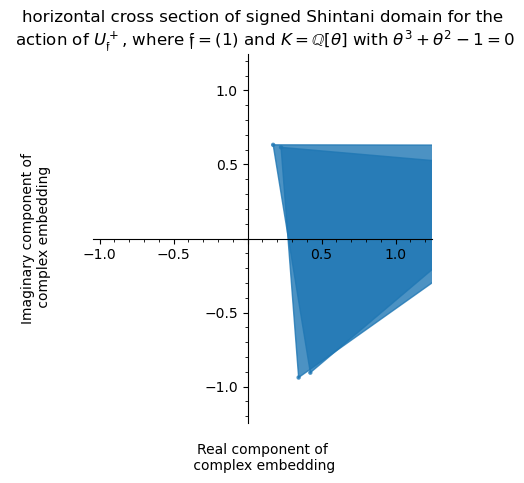

In [39]:
# domain.choose_rotations()
# graph_rotated_domain(domain) # graph domain with default rotations

# rotations = dict([])
# complex_embed = domain.field.complex_embeddings[0]
# for mu in domain.cones.keys():
#     cone_gens = domain.cones[mu]
#     column = embed(cone_gens, complex_embed)
#     rotations[mu] = compute_rotation(column, weighted = True)

# graph_rotated_domain(domain, rotations)

MATPLOTLIB ATTEMPT at graphing domain:

In [40]:
# # from matplotlib.pyplot import cm
# # import numpy as np
# # import matplotlib.pyplot as plt
# import matplotlib as mpl
# from itertools import cycle
# from matplotlib.patches import Polygon

# def mpl_graph_complex_proj(domain):
#     """Graph the Shintani domain as a projection onto the complex coordinates C."""
#     # graph = plt.figure()
#     ax = plt.gca()
#     cones = domain.cones.values()
#     complex_embed = domain.field.complex_embeddings[0]
#     colormap_name = "Set1"
#     cmap = mpl.colormaps[colormap_name]  # type: matplotlib.colors.ListedColormap
#     colors = cycle(cmap.colors)
#     alphas = cycle([1, 0.8, 0.6, 0.4])
#     # graph.set_prop_cycle(color = colors)
#     # colors = iter(cm.rainbow(np.linspace(0, 1, len(cones))))
#     for cone_gens in cones:
#         embeddings = embed(cone_gens, complex_embed)
#         points = []
#         for complex_num in embeddings:
#             point = []
#             point.append(complex_num.real())
#             point.append(complex_num.imag())
#             points.append(point)
#         triangle = Polygon(points, alpha = next(alphas), color = next(colors))
#         ax.add_patch(triangle)
#         print(ax)
#         # graph2 = plt.figure(ax)
#     plt.show()
# mpl_graph_complex_proj(domain)